# Import Packages


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import shap

# Suppressing Warnings
This command suppresses any warning messages generated during code execution by setting the filter to `'ignore'`. This results in cleaner output, allowing for a more focused view on the analysis or model training results without distractions from non-critical warnings.

In [2]:
warnings.filterwarnings('ignore')


# Data Overview
This command reads the Dataset into a Pandas DataFrame. Then using 5 rows from the dataset, provides a quick glimpse of its structure and values. This helps in understanding the data before further analysis or preprocessing.

In [3]:
df = pd.read_csv("./sonar_dataset.csv", header=None)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
157,0.0201,0.0178,0.0274,0.0232,0.0724,0.0833,0.1232,0.1298,0.2085,0.2720,...,0.0131,0.0049,0.0104,0.0102,0.0092,0.0083,0.0020,0.0048,0.0036,M
186,0.0209,0.0191,0.0411,0.0321,0.0698,0.1579,0.1438,0.1402,0.3048,0.3914,...,0.0078,0.0201,0.0104,0.0039,0.0031,0.0062,0.0087,0.0070,0.0042,M
46,0.0308,0.0339,0.0202,0.0889,0.1570,0.1750,0.0920,0.1353,0.1593,0.2795,...,0.0167,0.0127,0.0138,0.0090,0.0051,0.0029,0.0122,0.0056,0.0020,R
127,0.0209,0.0261,0.0120,0.0768,0.1064,0.1680,0.3016,0.3460,0.3314,0.4125,...,0.0057,0.0159,0.0085,0.0372,0.0101,0.0127,0.0288,0.0129,0.0023,M
98,0.1313,0.2339,0.3059,0.4264,0.4010,0.1791,0.1853,0.0055,0.1929,0.2231,...,0.0362,0.0210,0.0154,0.0180,0.0013,0.0106,0.0127,0.0178,0.0231,M


In [4]:
df.shape

(208, 61)

#Exploring Data Types

We examine the data types of each column to ensure they are correctly assigned, as this will impact how we process and analyze the data. Any necessary conversions will be made to align with the requirements of our XGBoost.

In [5]:
df.dtypes

,0
0,float64
1,float64
2,float64
3,float64
4,float64
...,...
56,float64
57,float64
58,float64
59,float64


# Checking for missing values

This command checks for any missing (NaN) values in the dataset. Identifying missing values at this stage is crucial for determining whether any data imputation or cleaning steps are needed before further analysis.

In [6]:
# check for nan values
df.isna().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
56,0
57,0
58,0
59,0


In [7]:
df.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60],
      dtype='int64')

# Dataset Dimensions Overview

This command retrieves the dataset's dimensions, showing the number of rows and columns. It offers a quick insight into the dataset's size, which is essential for planning further analysis or preprocessing.

In [8]:
df[60].value_counts() # label is not skewed

,count
60,
M,111
R,97


# Feature and Label Separation
This command separates the features and the label from the dataset. The features are stored in **X** by dropping the label column, while the labels are stored in **y**. The first few entries of the label data are then displayed, providing a quick view of the target variable that will be used for model training.

In [9]:
X = df.drop(60, axis=1)
y = df[60]
y.head()

,60
0,R
1,R
2,R
3,R
4,R


# One-Hot Encoding of Labels
This command applies one-hot encoding to the label data, converting categorical values into a binary format while dropping the first category to avoid multicollinearity. It then displays 5 random samples of the encoded labels to verify the transformation.

In [10]:
y = pd.get_dummies(y, drop_first=True)
y.sample(5)

,R
70,True
38,True
147,False
88,True
59,True


# Label Distribution Check
This command counts the occurrences of each unique value in the encoded label data. It provides insights into the distribution of the labels, helping to confirm whether they are balanced or skewed, which is important for ensuring effective model training.

In [11]:
y.value_counts()

,count
R,
False,111
True,97


In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


# Normalizing Features
This command selects numeric columns from the dataset, for those of type float64 and int64. It initializes a MinMaxScaler to scale these numeric columns to a range between 0 and 1. The scaling is applied to the selected numeric columns,to ensure that all features contribute equally to the model, we will normalize the numerical columns. This process scales the values so that they fall within a similar range, preventing features with larger magnitudes from disproportionately influencing the model

In [13]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
cols_to_scale = list(range(0, 61))  # Columns from index 0 to 60

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the numeric columns only
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


# Balancing Dataset
This command utilizes the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to address class imbalance in the dataset. It first separates the features and the target variable, then applies SMOTE to generate synthetic samples for the minority class. This helps to create a more balanced dataset. A new balanced DataFrame is constructed from the resampled data, and the value counts of the target column are printed to confirm that the classes are now balanced, which is crucial for improving model performance and reliability.

In [41]:
smote = SMOTE()

# Separate features and target variable
X = df.drop(60, axis=1)  # Assuming column 60 is your target variable
y = df[60]

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a balanced DataFrame from resampled data
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                         pd.DataFrame(y_resampled, columns=[60])], axis=1)

# Check the value counts of the target column to ensure balancing
print(df_balanced[60].value_counts())

60
R    111
M    111
Name: count, dtype: int64


# Splitting the Data: Train-Test Split
To evaluate the performance of our model, we will split the dataset into two parts: **training** and **testing sets**. The training set will be used to train the model, while the testing set will serve as unseen data to validate the model's performance. This ensures that the model generalizes well to new data and prevents overfitting.

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [43]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
67,0.260324,0.170167,0.099212,0.055873,0.190971,0.333244,0.305195,0.134068,0.011847,0.056199,...,0.057769,0.118402,0.402597,0.438596,0.170068,0.169231,0.375000,0.146453,0.212121,0.143187
14,0.080383,0.183026,0.193495,0.092962,0.134415,0.067992,0.134740,0.063506,0.144676,0.287001,...,0.077689,0.106990,0.135065,0.479532,0.412698,0.128205,0.315341,0.441648,0.402204,0.129330
164,0.109145,0.082297,0.061432,0.077984,0.173726,0.360656,0.393398,0.315105,0.350511,0.387387,...,0.026892,0.098431,0.054545,0.061404,0.174603,0.041026,0.230114,0.240275,0.225895,0.062356
179,0.279499,0.177454,0.141590,0.117214,0.134415,0.353131,0.249729,0.164719,0.228491,0.349635,...,0.117530,0.196862,0.090909,0.304094,0.058957,0.148718,0.278409,0.148741,0.143251,0.187067
19,0.081858,0.061294,0.205650,0.398003,0.633528,0.660306,0.788420,0.894157,0.726788,0.830402,...,0.152390,0.119829,0.077922,0.257310,0.260771,0.005128,0.505682,0.208238,0.316804,0.131640


# Using XGBoost for Sonar Classification

XGBoost is a powerful gradient boosting framework known for its speed and performance, making it suitable for large datasets and complex models. Its ability to handle missing values, prevent overfitting through regularization, and efficiently manage memory usage is particularly beneficial for this dataset. After training the model on the defined evaluation set, predictions are made on the test set, enabling assessment of the model's accuracy and effectiveness in classifying the target variable.


In [44]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform target variables in both training and test sets
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=400,
    max_depth=6,
    learning_rate=0.04,
    reg_alpha=0.01,
    reg_lambda=1,
    subsample=0.8
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train,
          eval_set=eval_set,
          verbose=False)

# Predict on the test set
preds = model.predict(X_test)


# Plotting Loss Graphs for Training and Testing Data
To evaluate the performance of our model during training, we will plot the loss curves for both the training and testing datasets. These graphs provide valuable insights into the model's learning process:

**Training Loss**: This curve shows how well the model is fitting the training data over time. A steadily decreasing loss indicates that the model is learning the underlying patterns.  
**Testing Loss**: This curve helps us monitor how well the model generalizes to unseen data. If the testing loss remains low, it suggests good generalization. However, if the testing loss increases while the training loss continues to decrease, it may indicate overfitting.  

By comparing the two curves, we can detect issues such as underfitting or overfitting and adjust the model accordingly.

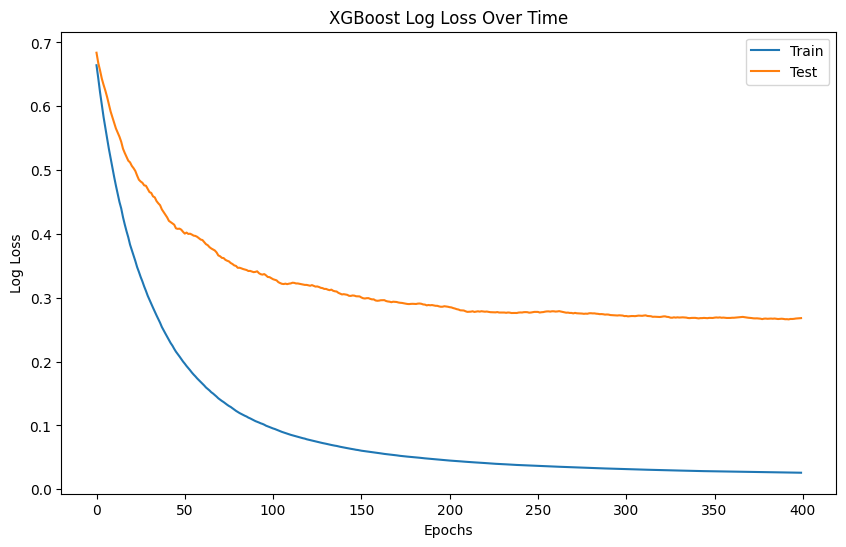

In [45]:
results = model.evals_result()

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Time')
plt.legend()
plt.show()





#Evaluating Model Performance: Accuracy, Precision, Recall, and F1-Score

A confusion matrix is a detailed summary of a classification model's performance. It compares actual versus predicted values. It categorizes the results into four key components: true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). This matrix serves as a crucial tool for evaluating how well the model differentiates between the two classes, "Class M" and "Class R".

By analyzing the confusion matrix, we can identify the strengths and weaknesses of our classification model, paving the way for further improvements and refinements. In addition to the confusion matrix, we use several key metrics to assess the effectiveness of our classification model. These metrics provide a deeper understanding of the model's performance.



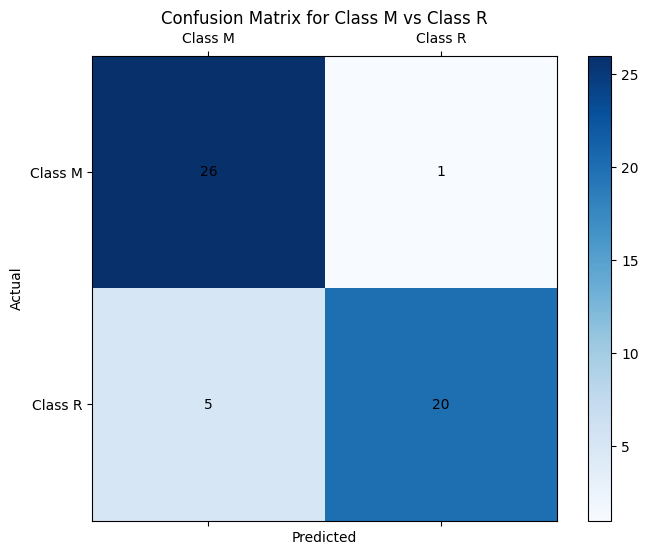

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)

# Define custom labels based on your dataset ('M' and 'R')
labels = ['Class M', 'Class R']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
plt.colorbar()

# Label the axes and set custom tick marks with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

# Add numerical values inside the matrix
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f'{val}', ha='center', va='center', color='black')

plt.title('Confusion Matrix for Class M vs Class R')
plt.show()

In addition to the confusion matrix, we use several key metrics to assess the effectiveness of our classification model. These metrics provide a deeper understanding of the model's performance:



1.   **Accuracy**: This metric reflects the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. While accuracy is a useful measure, it may be misleading in cases of class imbalance, as it does not differentiate between types of errors.

2.   **Precision**: This metric calculates the proportion of true positive predictions among all positive predictions. A high precision score indicates that the model has fewer false positives, meaning it is reliable when it predicts the positive class.


3. **F-1 Score:** The F1 score is the harmonic mean of precision and recall, providing a balanced measure that is especially valuable when dealing with imbalanced datasets. It captures the trade-off between precision and recall, offering insight into the model’s overall accuracy.

4. **Recall:** Recall measures the proportion of true positives among all actual positive cases. A high recall score signifies that the model successfully identifies most of the positive instances, reducing the number of false negatives.

These metrics, derived from the confusion matrix, allow us to assess the model's ability to handle both positive and negative predictions and avoid biases that can arise from imbalanced data. By considering all of these measures, we ensure a more comprehensive evaluation of the model’s performance.





In [47]:
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.2f}")
report = classification_report(y_test, preds)
print("Classification Report:")
print(report)

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        27
           1       0.95      0.80      0.87        25

    accuracy                           0.88        52
   macro avg       0.90      0.88      0.88        52
weighted avg       0.89      0.88      0.88        52



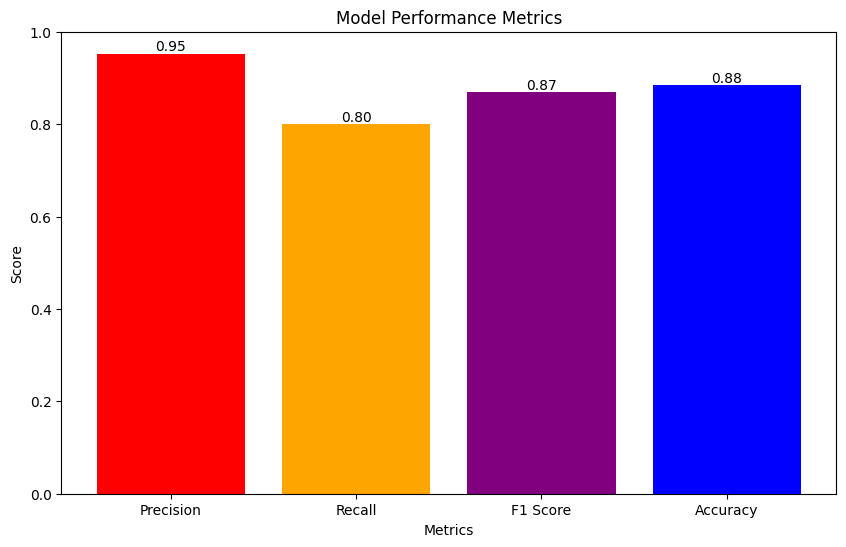

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming preds are your predictions and y_test is the true labels
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)

# Create a bar plot
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [precision, recall, f1, accuracy]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['red', 'orange', 'purple', 'blue'])
plt.ylim(0, 1)  # Set the limit for y-axis
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')

# Add value annotations on top of the bars
for index, value in enumerate(values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

#Understanding Feature Importance

To gain a clearer understanding of which features significantly impact our sonar signal classification model, we will employ two methods:

**XGBoost Built-in Feature Importance:** This method provides a quick ranking of the most influential features in making predictions related to sonar classification.

**SHAP (SHapley Additive exPlanations):** SHAP offers a more nuanced approach to visualize feature importance, detailing how each feature contributes to the model’s predictions.

By utilizing both methods, we can effectively compare and validate the key features that influence sonar signal classification, ensuring a comprehensive understanding of our model's decision-making process.

<Figure size 1200x800 with 0 Axes>

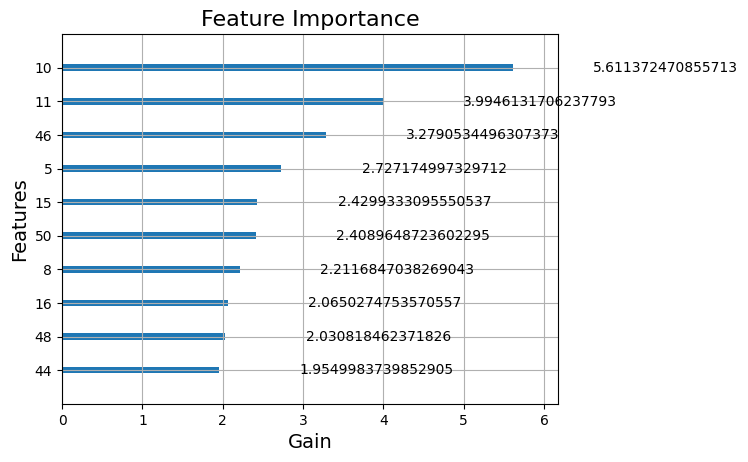

In [30]:
plt.figure(figsize=(12, 8))

# Plot importance
xgb.plot_importance(
    model,
    importance_type='gain',
    max_num_features=10,  # Show top 10 features
    title='Feature Importance',
    xlabel='Gain',
    ylabel='Features',
    orientation='horizontal'  # Change to horizontal for better readability
)

plt.title('Feature Importance', fontsize=16)
plt.xlabel('Gain', fontsize=14)
plt.ylabel('Features', fontsize=14)

plt.show()

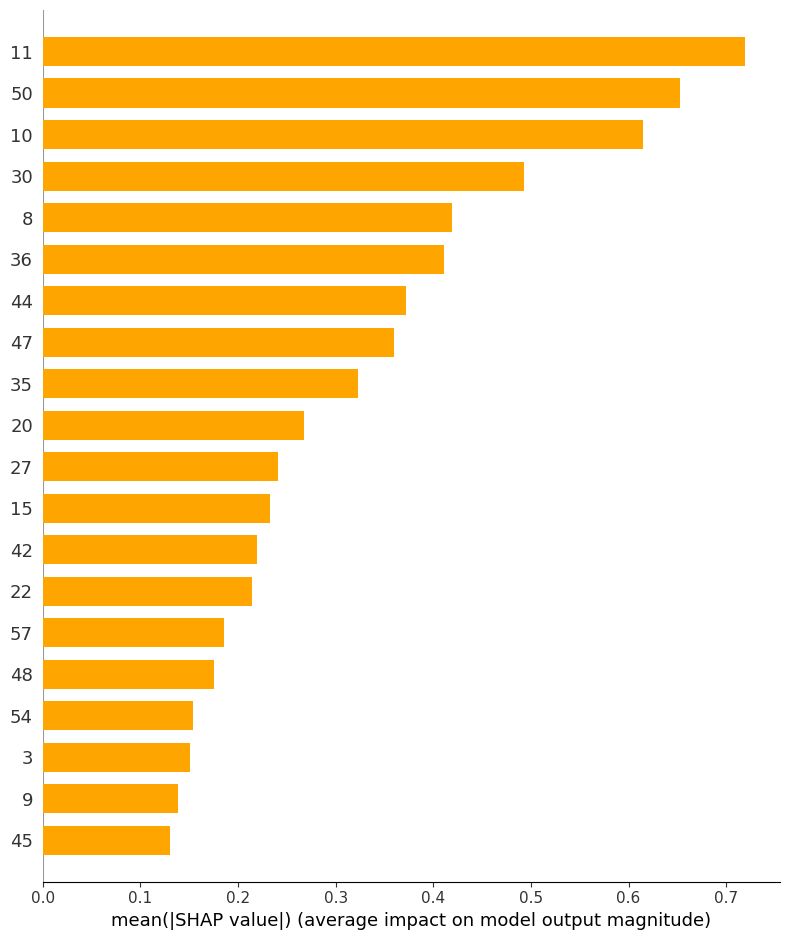

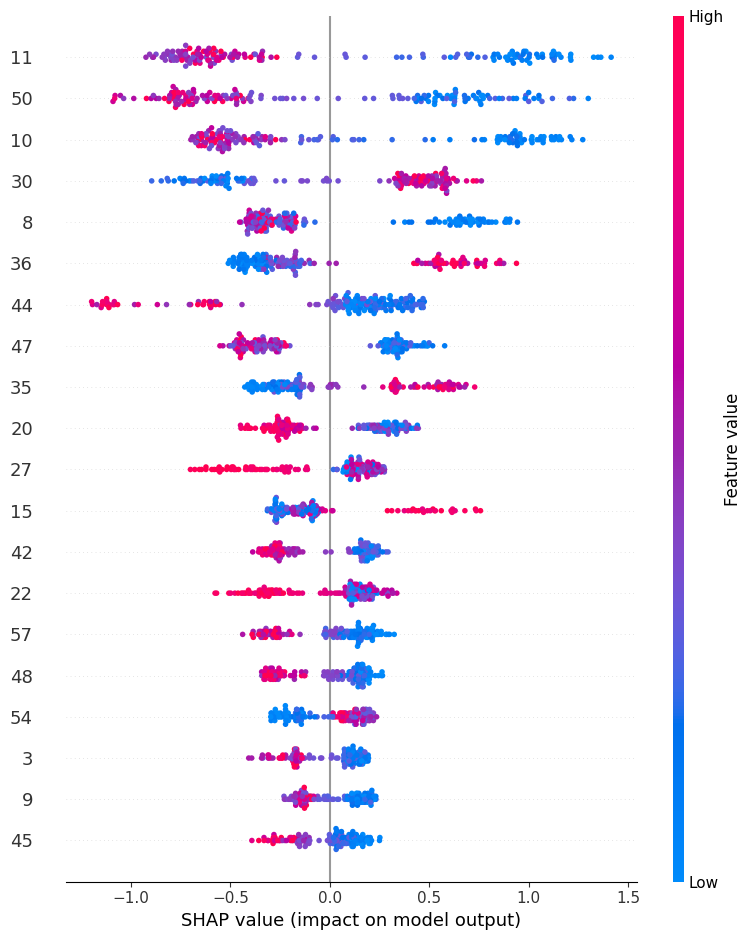

In [33]:
# Initialize the SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values for the training data
shap_values = explainer(X_train)

# Plot a bar chart of feature importance with horizontal bars in orange
shap.summary_plot(shap_values, X_train, plot_type="bar", color='orange')

# Plot a detailed summary of SHAP values across samples
shap.summary_plot(shap_values, X_train, color='orange')
